In [2]:
import pyodbc
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

conn=pyodbc.connect('Driver={SQL Server};'
                    'Server=localhost;'
                    'Database=MentalHealthDB;'
                    'Trusted_Connection=yes;')

query="SELECT * FROM MentalHealthDataset"
df=pd.read_sql(query, conn)
df=df.drop('User_ID', axis=1)
print(df)

      Age             Gender  Occupation    Country Mental_Health_Condition  \
0    36.0         Non-binary       Sales     Canada                      No   
1    34.0             Female   Education         UK                     Yes   
2    65.0         Non-binary       Sales        USA                     Yes   
3    34.0               Male       Other  Australia                      No   
4    22.0             Female  Healthcare     Canada                     Yes   
..    ...                ...         ...        ...                     ...   
995  46.0         Non-binary       Other    Germany                      No   
996  31.0               Male       Sales     Canada                      No   
997  33.0             Female          IT    Germany                      No   
998  42.0             Female     Finance  Australia                     Yes   
999  43.0  Prefer not to say       Sales    Germany                      No   

    Severity Consultation_History Stress_Level  Sle

C:\Users\jeffg\AppData\Local\Temp\ipykernel_30424\2134214505.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df=pd.read_sql(query, conn)


In [3]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
#X=df[['Age', 'Gender', 'Occupation',
#      'Country', 'Mental_Health_Condition', 'Severity', 'Consultation_History', 'Stress_Level']]
#Y=df['Work_Hours']
numeric=df[['Age', 'Sleep_Hours', 'Work_Hours', 'Physical_Activity_Hours']]
categoric=df[['Gender', 'Occupation', 'Country', 'Mental_Health_Condition', 'Severity', 'Consultation_History', 'Stress_Level']]

#Preprocessing Steps
#Handling categorical values
label_encoders={}
for i in categoric:
    label_encoders[i]=LabelEncoder()
    df[i]=label_encoders[i].fit_transform(df[i].astype(str))
print(df.head())

#Normalize numerical features
numerical_columns=['Age', 'Sleep_Hours', 'Work_Hours', 'Physical_Activity_Hours']
scaler=StandardScaler()
df[numerical_columns]=scaler.fit_transform(df[numerical_columns])
print(df.head())

    Age  Gender  Occupation  Country  Mental_Health_Condition  Severity  \
0  36.0       2           6        1                        0         2   
1  34.0       0           0        5                        1         3   
2  65.0       2           6        6                        1         0   
3  34.0       1           5        0                        0         1   
4  22.0       0           3        1                        1         1   

   Consultation_History  Stress_Level  Sleep_Hours  Work_Hours  \
0                     1             2          7.1        46.0   
1                     0             1          7.5        47.0   
2                     0             1          8.4        58.0   
3                     0             2          9.8        30.0   
4                     0             2          4.9        62.0   

   Physical_Activity_Hours  
0                      5.0  
1                      8.0  
2                     10.0  
3                      2.0  
4      

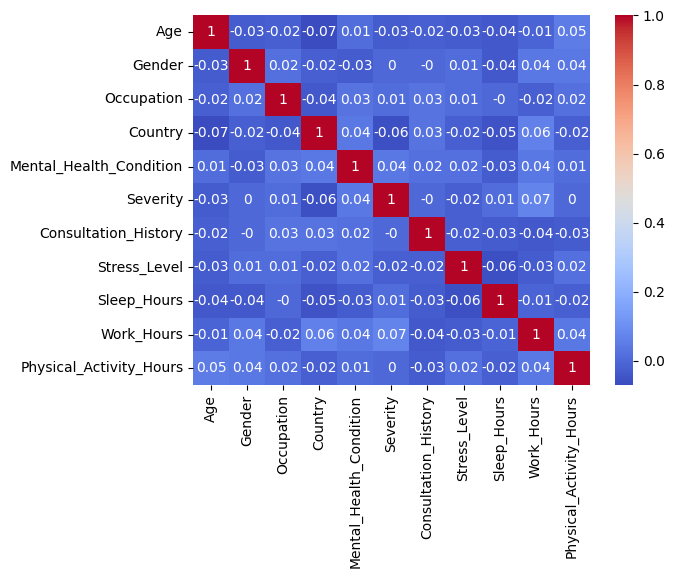

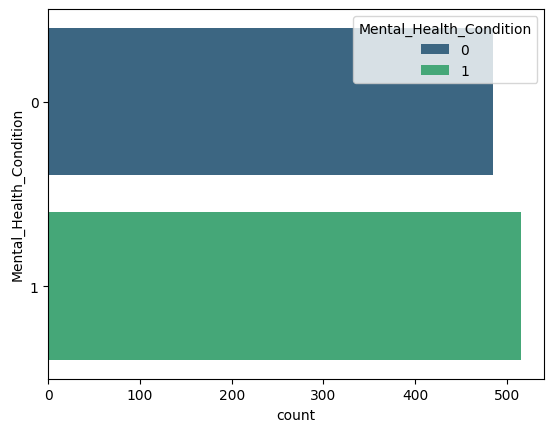

In [4]:
# Normalized correlation matrix
corr_matrix=df.corr(numeric_only=True).round(2)
sns.heatmap(data=corr_matrix, annot=True, cmap="coolwarm")
plt.show()

# Distribution of binary classification variable
sns.countplot(df, y="Mental_Health_Condition", hue="Mental_Health_Condition", palette="viridis")
plt.show()

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# Analyzing feature importance
x=df.drop('Mental_Health_Condition', axis=1)
y=df['Mental_Health_Condition']

# Select top 8 features
selector=SelectKBest(f_classif, k=5)
selected=selector.fit_transform(x, y)
features=x.columns[selector.get_support()].tolist()

print("Most relevant features:", features)

Most relevant features: ['Gender', 'Occupation', 'Country', 'Severity', 'Consultation_History', 'Stress_Level', 'Sleep_Hours', 'Work_Hours']


In [6]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test=train_test_split(selected, y, test_size=0.2, random_state=5)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(800, 8)
(200, 8)
(800,)
(200,)


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# Logistic Regression
lr_model=LogisticRegression(max_iter=1000, random_state=5)
lr_model.fit(x_train, y_train)
lr_pred=lr_model.predict(x_test)

# Decision Tree
dt_model=DecisionTreeClassifier(random_state=5)
dt_model.fit(x_train, y_train)
dt_pred=dt_model.predict(x_test)

#Perform cross-validation on LR
lr_scores=cross_val_score(lr_model, x_train, y_train, scoring='accuracy', cv=10)
#Perform cross-validation on DT
dt_scores=cross_val_score(dt_model, x_train, y_train, scoring='accuracy', cv=10)

#Cross validation results
print("LR 10-fold cross validation result:")
print("----------------------------")
print("Accuracy is {}".format((lr_scores))+"\n")
print("Average Accuracy is {}".format(np.mean(lr_scores))+"\n")

print("DT 10-fold cross validation result:")
print("----------------------------")
print("Accuracy is {}".format((dt_scores))+"\n")
print("Average Accuracy is {}".format(np.mean(dt_scores))+"\n")

LR 10-fold cross validation result:
----------------------------
Accuracy is [0.5125 0.425  0.5625 0.525  0.4125 0.3875 0.5875 0.525  0.525  0.55  ]

Average Accuracy is 0.50125

DT 10-fold cross validation result:
----------------------------
Accuracy is [0.5125 0.575  0.45   0.575  0.4625 0.5125 0.6125 0.55   0.4375 0.4625]

Average Accuracy is 0.515



In [8]:
from sklearn.metrics import classification_report

# Evaluate Models
print("Logistic Regression Performance: ")
print(classification_report(y_test, lr_pred))

print("Decision Tree Performance: ")
print(classification_report(y_test, dt_pred))

print("Class Distribution: ")
print(y.value_counts(normalize=True))

Logistic Regression Performance: 
              precision    recall  f1-score   support

           0       0.49      0.41      0.44        98
           1       0.51      0.59      0.55       102

    accuracy                           0.50       200
   macro avg       0.50      0.50      0.49       200
weighted avg       0.50      0.50      0.50       200

Decision Tree Performance: 
              precision    recall  f1-score   support

           0       0.48      0.49      0.49        98
           1       0.50      0.50      0.50       102

    accuracy                           0.49       200
   macro avg       0.49      0.49      0.49       200
weighted avg       0.50      0.49      0.50       200

Class Distribution: 
1    0.515
0    0.485
Name: Mental_Health_Condition, dtype: float64


In [9]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix to check True Positives, False Negatives, etc.
cm=confusion_matrix(y_test, lr_pred)
TN, FP, FN, TP=confusion_matrix(y_test, lr_pred).ravel()
print('True Positive (TP) = ', TP)
print('False Positive (FP) = ', FP)
print('True Negative (TN) = ', TN)
print('False Negative (FN) = ', FN)
print("\n")
cm=confusion_matrix(y_test, dt_pred)
TN, FP, FN, TP=confusion_matrix(y_test, dt_pred).ravel()
print('True Positive (TP) = ', TP)
print('False Positive (FP) = ', FP)
print('True Negative (TN) = ', TN)
print('False Negative (FN) = ', FN)

True Positive (TP) =  60
False Positive (FP) =  58
True Negative (TN) =  40
False Negative (FN) =  42


True Positive (TP) =  51
False Positive (FP) =  50
True Negative (TN) =  48
False Negative (FN) =  51


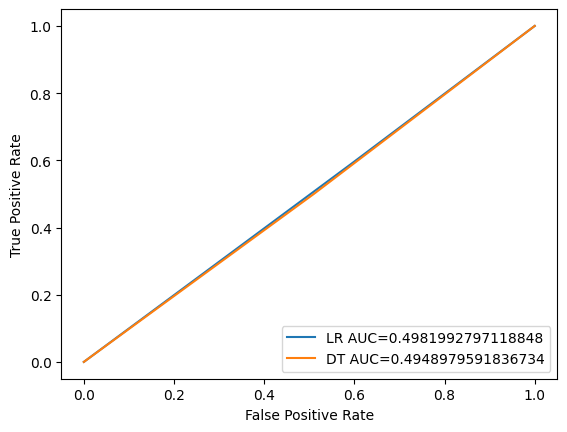

In [ ]:
from sklearn.metrics import roc_curve, auc

# Define Logistic Regression metrics
lr_probs=lr_model.predict_proba(x_test)[:,1]
lr_fpr, lr_tpr, _=roc_curve(y_test, lr_pred)
lr_auc=auc(lr_fpr, lr_tpr)

# Define Decision Tree metrics
dt_probs=dt_model.predict_proba(x_test)[:,1]
dt_fpr, dt_tpr, _=roc_curve(y_test, dt_pred)
dt_auc=auc(dt_fpr, dt_tpr)

#Create ROC curve comparison
plt.plot(lr_fpr, lr_tpr, label="LR AUC="+str(lr_auc))
plt.plot(dt_fpr, dt_tpr, label="DT AUC="+str(dt_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

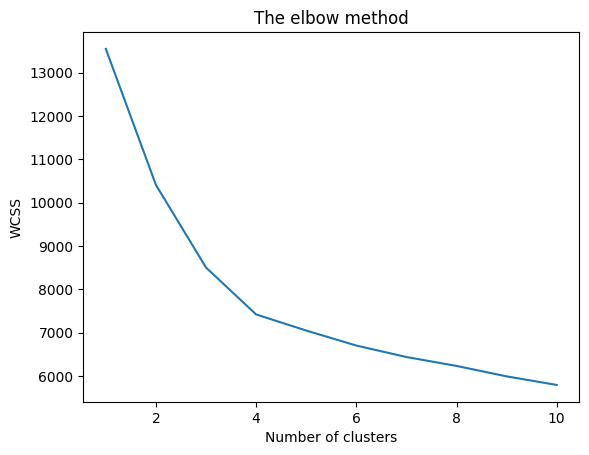

In [19]:
#Implementing Clustering
from sklearn.cluster import KMeans

#Finding the optimum number of clusters for k-means classification, with the most relevant features
x_values=df.iloc[:, [1, 2, 3, 5, 6, 7, 8, 9]].values
#x_values=df.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]].values
wcss=[]

for i in range(1, 11):
    kmeans=KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(x_values)
    wcss.append(kmeans.inertia_)

#Using elbow method to determine optimal number of clusters
plt.plot(range(1,11), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

(1000, 8)


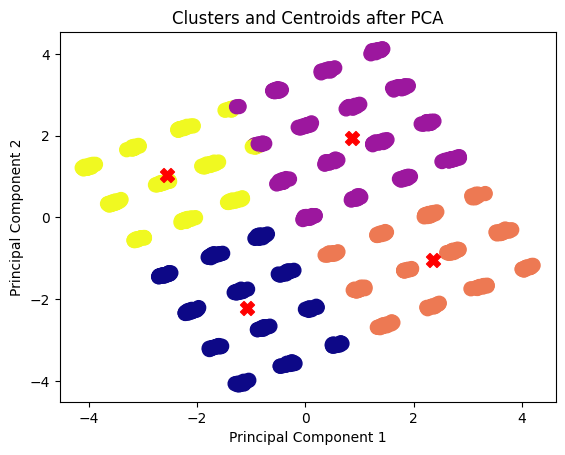

In [20]:
from sklearn.decomposition import PCA
#Implementing k-means clustering
kmeans=KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_kmeans=kmeans.fit_predict(x_values)

"""
plt.scatter(x_values[:, 0], x_values[:, 1], c=y_kmeans, cmap='plasma', s=100)
centers=kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, marker='X')
plt.title('Clusters and Centroids')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()
"""

#Reduce dimensions using PCA
pca=PCA(n_components=2)
pca_x_values=pca.fit_transform(x_values)

print(selected.shape)
plt.scatter(pca_x_values[:, 0], pca_x_values[:, 1], c=y_kmeans, cmap='plasma', s=100)
centers=kmeans.cluster_centers_
pca_centers=pca.transform(centers)
plt.scatter(pca_centers[:, 0], pca_centers[:, 1], c='red', s=100, marker='X')
plt.title('Clusters and Centroids after PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()